In [2115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import optimize
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2941]:
array_shape = (8,8)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [2942]:
def get_baseline_key(i1, i2, shape=array_shape):
    # Comfort function to get the baseline from given two antenna indices 
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [2943]:
def get_num_baselines(tele_num=telescope_number):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*tele_num - 2*np.sqrt(tele_num)
    return int(N_bases)

In [2944]:
def get_baselines_np(tele_num=telescope_number):
    # Creates array of sparse (tele_num, tele_num) matrices
    # Each matrix is symmetric with 1 at (i,j) if (i-j) gives the relevant baseline
    base_size = get_num_baselines(tele_num)
    
    redundant_baselines = np.zeros((base_size, tele_num, tele_num))
    
    baseline_indx = []
    for i in range(tele_num):
        for k in range(tele_num):
            if i==k:
                continue
            key = get_baseline_key(i,k)
            if key in baseline_indx:
                red_indx = baseline_indx.index(key)
                redundant_baselines[red_indx][i,k] = 1
            else:
                baseline_indx.append(key)
                redundant_baselines[len(baseline_indx)-1][i,k] = 1
    return redundant_baselines, baseline_indx

In [2945]:
# Get our necessary information on the baselines
redundant_baselines, baseline_indx = get_baselines_np()
n_bases = get_num_baselines(telescope_number)

In [2946]:
def get_baseline_indx(i1, i2, base_idx = baseline_indx):
    # Comfort function to get index of baseline from the given antenna index 
    # (i,j) -> 𝛼
    key = get_baseline_key(i1, i2)
    return base_idx.index(key)

In [3339]:
# Useful functions to have on hand
rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)
rand_sign = lambda x : np.array([-1,1])[np.random.randint(0,2, x)]
npcb = np.vectorize(pow)

In [3365]:
def make_gains(tele_num=telescope_number):
    # Create complex gains with either (amplitude, phase) or (real, imaginary)
    
    gain_amp = np.random.normal(1, .05, tele_num)
    gain_phase = rand_phases(tele_num)
    tgain = gain_amp*np.exp(1j*gain_phase)
    
    return tgain, gain_phase

    # |gain| ≈ 1
#     gain_factor = np.sqrt(2)/2
#     tgain = rand_sign(tele_num)*np.random.normal(gain_factor, .1, size=tele_num) + 1j*rand_sign(tele_num)*np.random.normal(gain_factor, .1, size=tele_num)
#     gain_phase = np.angle(tgain)

    return tgain.flatten(), gain_phase.flatten()

In [3369]:
def make_visibilities(tele_num=telescope_number):
    # Create complex visibilities with either (amplitude, phase) or (real, imaginary)
    n_bases = get_num_baselines(telescope_number)
    
    sky_phase = rand_phases(n_bases)
    correl_sky = np.random.normal(0, 3, n_bases)*np.exp(1j*sky_phase)
    
#     correl_sky = np.random.normal(0, 2, (n_bases,2)).view(np.complex128)
#     sky_phase = np.angle(correl_sky)

    return correl_sky.flatten(), sky_phase.flatten()

In [3370]:
def make_uv_points(tg, va, tele_num=telescope_number, noise_amp=.01, noise_sig=.005):
    # Create UV points given gains, visibilities and noise parameters if appropriate
    observation_baselines = np.zeros((tele_num, tele_num), dtype=np.complex128)
    # Unsymmetric noise matrix
    unsym_noise = np.random.normal(noise_amp, noise_sig, (tele_num, tele_num)) + 1j*np.random.normal(noise_amp, noise_sig, (tele_num, tele_num))
    # Make a Hermetian noise matrix
    noise_matrix = (unsym_noise + np.conj(unsym_noise).T)*.5
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            # Arbitrarily decide which "direction" gets conjugated and which does not for V_𝛼
            if i < k:
                vaterm = va[red_indx]
            else:
                vaterm = np.conj(va[red_indx])
            noise = noise_matrix[i,k]
            signal = tg[i]*np.conj(tg[k])*vaterm
            observation_baselines[i,k] = signal+noise
    return observation_baselines, noise_matrix

In [3377]:
# Create gains and visibilities
tgain, gain_phase = make_gains()
valpha, v_phase = make_visibilities()

In [3378]:
# Create UV observations
observation_baselines, noises = make_uv_points(tgain, valpha)

In [3379]:
snr = np.mean(np.abs(observation_baselines)/np.mean(np.abs(noises)))
print("SNR is %f" % snr)

SNR is 244.500997


In [3298]:
def omnical(iter_max, obs, g0, v0, sigma, delta=.4, epsilon=1e-5):
    # Following OMNI algorithm in HERA paper
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)+16
    chisqr = []
    garr = g0.copy()
    varr = v0.copy()
    y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
    
    for n in range(iter_max):
        
        gdiv = np.divide(w_ij*obs, y_ij, out=np.zeros_like(w_ij), where=(y_ij!=0))
        gprime = garr * gdiv.sum(axis=1)/(w_ij.sum(axis=1))
        garr = (1 - delta)*garr + delta*gprime

        vprime = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            numer = ((w_ij[indxs]*obs[indxs])/y_ij[indxs]).sum()
            denom = (w_ij[indxs]).sum()
            vprime[i] = varr[i]*numer/denom
        varr = (1-delta)*varr + delta*vprime

        # Using median since mean will make all of them blow up if one blows up
        gscale = 1/np.median(np.abs(garr))
        vscale = (1/gscale)**2
        garr = garr*gscale
        varr = varr*vscale

        y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
        # i < j --> Either lower triangular or upper triangular matrix
        chiscore = np.triu((np.abs(y_ij - observation_baselines)**2)/(sigma.real**2*2)).sum()
        chisqr.append(chiscore)
        if n > 20:
            if np.abs((chisqr[-1] - chisqr[-2])) < epsilon:
                break
    return garr, varr, chisqr, n

In [3374]:
def chimincal(iter_max, obs, g0, v0, sigma, delta=.4, epsilon=1e-5):
    # Following our chi2 minimization
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    score = []
    chisqr = []
    garr = g0.copy()
    varr = v0.copy()
    N = 1
    
    for n in range(iter_max):    
        vprime = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            clean_l = []
            clean_k = []
            for l,k in zip(*indxs):
                if l < k:
                    clean_l.append(l)
                    clean_k.append(k)
            new_indx = (clean_l, clean_k)
            numer = (obs[new_indx]).sum()
            denom = (garr[clean_l]*np.conj(garr[clean_k])).sum()
            vprime[i] = numer/denom - varr[i]
            
        varr += vprime
        
        
        gprime = np.zeros(telescope_number, dtype=np.complex128)
        numer = np.zeros_like(gprime)
        denom = np.zeros_like(gprime)
        for i in range(telescope_number):
            for k in range(telescope_number):
                if i==k:
                    continue
                else:
                    v_indx = get_baseline_indx(i,k)
                    if i < k:
                        vterm = varr[v_indx]
                    else:
                        vterm = np.conj(varr[v_indx])
                    g2 = np.conj(garr[k])
                    numer[i] += obs[i,k]*np.conj(g2)*np.conj(vterm)
                    denom[i] += np.abs(g2*vterm)**2

            gprime[i] = numer[i]/denom[i]
        garr = gprime
        
        # Using median since mean will make all of them blow up if one blows up
        gscale = N/np.median(np.abs(garr))
        garr *= gscale
        varr *= (1/gscale)**2
        
        y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
            
        # i < j --> Either lower triangular or upper triangular matrix
        chiscore = np.triu((np.abs(y_ij - observation_baselines)**2)/(sigma.real**2*2)).sum()
        chisqr.append(chiscore)
        if n > 20:
            if np.abs(chisqr[-1] - chisqr[-2]) < epsilon:
                break
        
    return garr, varr, chisqr, n

In [3375]:
def compare(true_gain, true_va, reps, noise_a=.01, noise_s=.005, **kwargs):
    tgain = true_gain.copy()
    tvalp = true_va.copy()
    # Set up variables to fill in during the runs

    omni_gains = np.zeros((reps, len(tgain)), dtype=np.complex128)
    chi_gains = np.zeros_like(omni_gains)
    omni_chi_gains = np.zeros_like(omni_gains)
    omni_avg_gain = np.zeros_like(omni_gains)
    chi_avg_gain = np.zeros_like(omni_avg_gain)
    
    omni_valp = np.zeros((reps, len(tvalp)), dtype=np.complex128)
    chi_valp = np.zeros_like(omni_valp)
    omni_chi_valp = np.zeros_like(omni_valp)
    omni_avg_valp = np.zeros_like(omni_valp)
    chi_avg_valp = np.zeros_like(omni_valp)
    omni_chis = []
    chi_chis = []
    guess_chis = []
    fin_n = np.zeros((reps, 2))
    
    n_sigma = np.zeros((telescope_number, telescope_number))+(noise_s + noise_s*1j)

    for n in tqdm(range(reps)):
        # Generate observed data
        uv_points, _ = make_uv_points(tgain, tvalp, noise_amp=noise_a, noise_sig=noise_s)
        # Set up guesses
        vguess = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            clean_l = []
            clean_k = []
            for l,k in zip(*indxs):
                if l < k:
                    clean_l.append(l)
                    clean_k.append(k)
            new_indx = (clean_l, clean_k)
            vguess[i] = np.mean(uv_points[new_indx])
            
        gguess = tgain*np.exp(1j*np.random.uniform(-np.pi/12, np.pi/12, telescope_number))
        guess_uv, _ = make_uv_points(gguess, vguess, noise_amp=0, noise_sig=0)
        guess_chis.append(np.triu((np.abs(guess_uv - observation_baselines)**2)/(n_sigma.real**2*2)).sum())

        # Solve with different methods
        gomni, vomni, omnichi, omnin = omnical(obs=uv_points, g0=gguess, v0=vguess, sigma=n_sigma, **kwargs)
        gchi, vchi, chichi, chin = chimincal(obs=uv_points, g0=gguess, v0=vguess, sigma=n_sigma, **kwargs)
        # Put results in the right place
        omni_avg_gain[n] = gomni
        omni_avg_valp[n] = vomni
        
        chi_avg_gain[n] = gchi
        chi_avg_valp[n] = vchi
        
        omni_gains[n] = gomni - tgain
        chi_gains[n] = gchi - tgain
        omni_chi_gains[n] = gomni - gchi
        
        omni_valp[n] = vomni - tvalp
        chi_valp[n] = vchi - tvalp
        omni_chi_valp[n] = vomni - vchi
        
        omni_chis.append(omnichi)
        chi_chis.append(chichi)
        
        fin_n[n] = (omnin, chin)
    # Using median to stop one bad apple from blowing up averages
    fomni_avg_gain = np.median(omni_avg_gain, axis=0)
    fomni_avg_valp = np.median(omni_avg_valp, axis=0)
    fchi_avg_gain = np.median(chi_avg_gain, axis=0)
    fchi_avg_valp = np.median(chi_avg_valp, axis=0)
    
    return omni_gains, chi_gains, omni_chi_gains, omni_valp, chi_valp, omni_chi_valp, omni_chis, chi_chis, guess_chis, fin_n, fomni_avg_gain, fomni_avg_valp, fchi_avg_gain, fchi_avg_valp

In [3132]:
# Optional arguments for chimin and omnical
compare_dict = {"iter_max": 400, "delta": .2, "epsilon": 1e-5}

In [3133]:
# Get trials data
trials = compare(tgain, valpha, 5, **compare_dict)

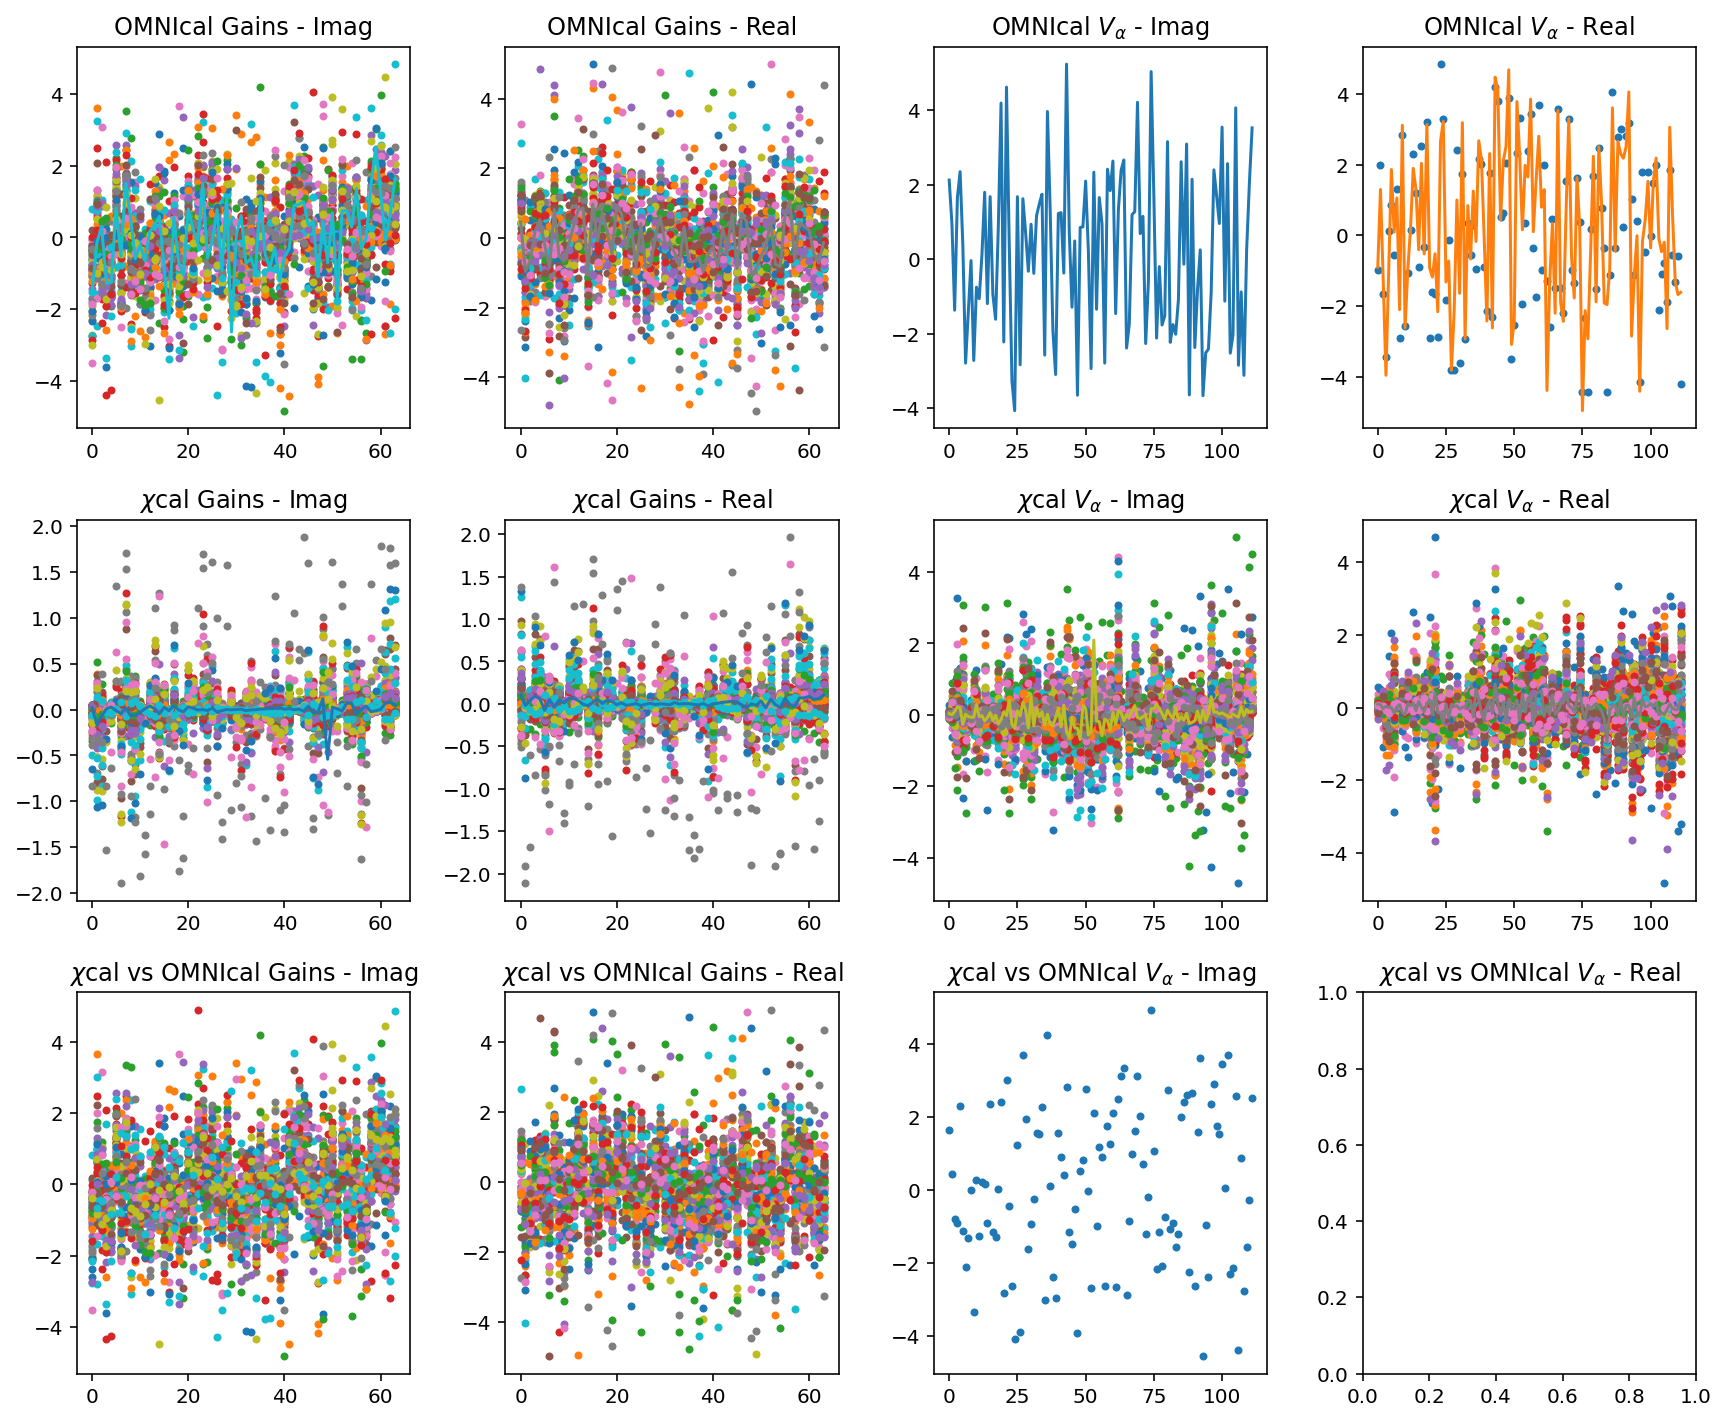

In [3148]:
# Lots of plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10))
# Simple filter to remove plots that blew up/clearly bad
iflambda = lambda x : np.max(np.abs(x)) < 5 and True

for i in trials[0].imag:
    if iflambda(i):
        axes[0,0].plot(i, '.')
axes[0,0].plot((trials[-4] - tgain).imag)
axes[0,0].set_title("OMNIcal Gains - Imag")

for i in trials[0].real:
    if iflambda(i):
        axes[0,1].plot(i, '.')
axes[0,1].plot((trials[-4] - tgain).real)
axes[0,1].set_title("OMNIcal Gains - Real")

for i in trials[3].imag:
    if iflambda(i):
        axes[0,2].plot(i, '.')
axes[0,2].plot((trials[-3] - valpha).imag)
axes[0,2].set_title(r"OMNIcal $V_\alpha$ - Imag")

for i in trials[3].real:
    if iflambda(i):
        axes[0,3].plot(i, '.')
axes[0,3].plot((trials[-3] - valpha).real)
axes[0,3].set_title(r"OMNIcal $V_\alpha$ - Real")

for i in trials[1].imag:
    if iflambda(i):
        axes[1,0].plot(i, '.')
axes[1,0].plot((trials[-2] - tgain).imag)
axes[1,0].set_title(r"$\chi$cal Gains - Imag")

for i in trials[1].real:
    if iflambda(i):
        axes[1,1].plot(i, '.')
axes[1,1].plot((trials[-2] - tgain).real)
axes[1,1].set_title(r"$\chi$cal Gains - Real")

for i in trials[4].imag:
    if iflambda(i):
        axes[1,2].plot(i, '.')
axes[1,2].plot((trials[-1] - valpha).imag)
axes[1,2].set_title(r"$\chi$cal $V_\alpha$ - Imag")

for i in trials[4].real:
    if iflambda(i):
        axes[1,3].plot(i, '.')
axes[1,3].plot((trials[-1] - valpha).real)
axes[1,3].set_title(r"$\chi$cal $V_\alpha$ - Real")

for i in trials[2].imag:
    if iflambda(i):
        axes[2,0].plot(i, '.')
axes[2,0].set_title(r"$\chi$cal vs OMNIcal Gains - Imag")

for i in trials[2].real:
    if iflambda(i):
        axes[2,1].plot(i, '.')
axes[2,1].set_title(r"$\chi$cal vs OMNIcal Gains - Real")

for i in trials[5].imag:
    if iflambda(i):
        axes[2,2].plot(i, '.')
axes[2,2].set_title(r"$\chi$cal vs OMNIcal $V_\alpha$ - Imag")

for i in trials[5].real:
    if iflambda(i):
        axes[2,3].plot(i, '.')
axes[2,3].set_title(r"$\chi$cal vs OMNIcal $V_\alpha$ - Real")



plt.tight_layout()

In [3329]:
# Extract relevant chi2 information from the trials and calculate DoF
degree_of_freedoms = np.prod(observation_baselines.shape)-telescope_number - 2*(n_bases + telescope_number)
omni_chis, chi_chis, start_chi = trials[6], trials[7], trials[8]
init_omni_chis = [np.abs(chis[0]) for chis in omni_chis]
init_chi_chis = [np.abs(chis[0]) for chis in chi_chis]
last_omni_chis = [chis[-1] for chis in omni_chis]
last_chi_chis = [chis[-1] for chis in chi_chis]

In [3376]:
# chi2 doesn't throw away runs that blew up so manually remove any chi2 values that are major outliers
#last_omni_chis.pop(last_omni_chis.index(max(last_omni_chis)));
# last_chi_chis.pop(last_chi_chis.index(max(last_chi_chis)));

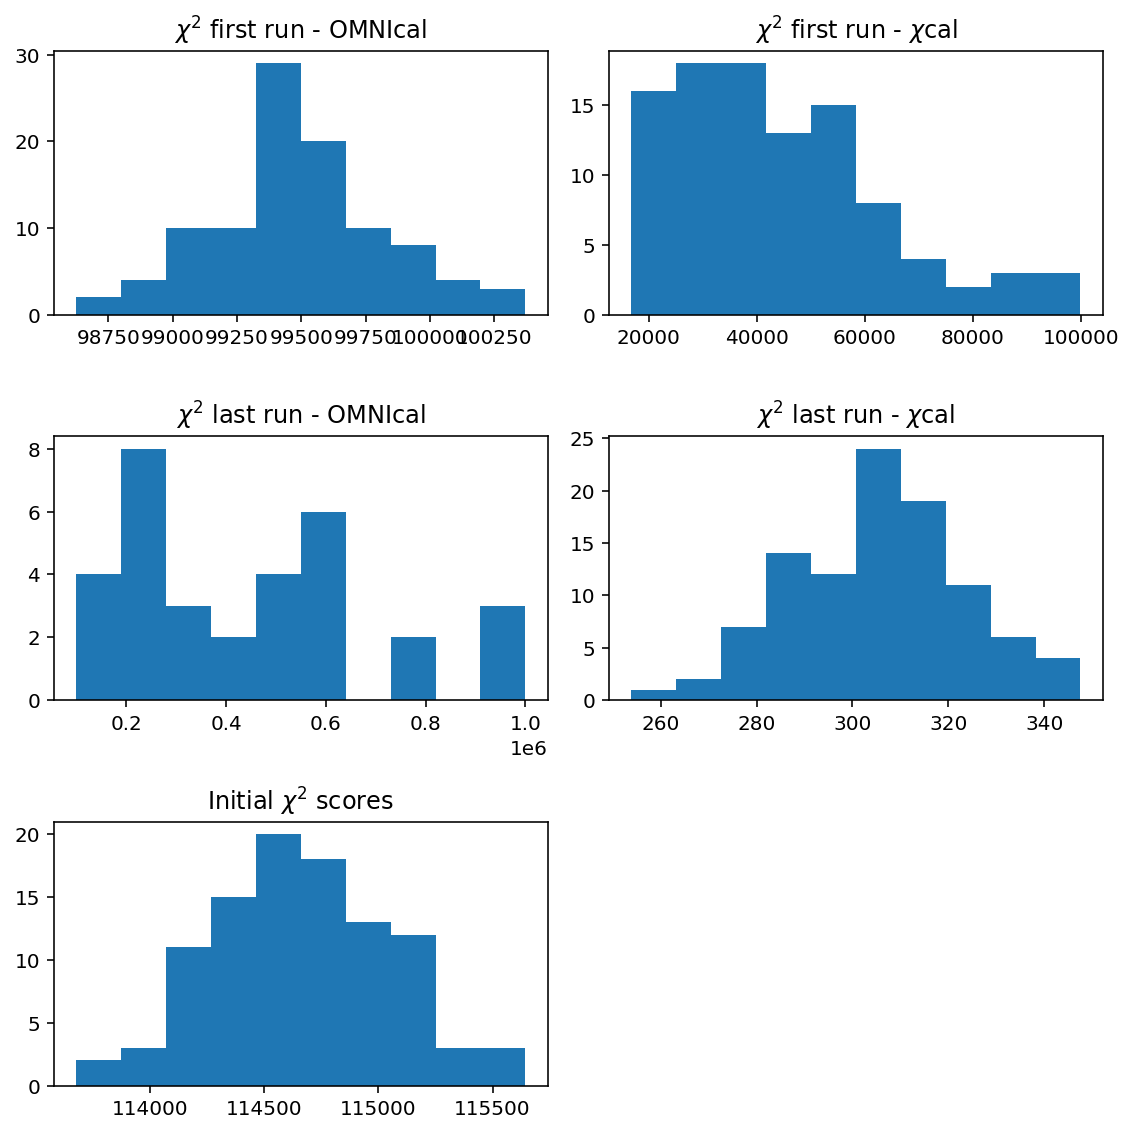

In [3161]:
# chi2 plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

axes[0,0].hist(init_omni_chis/degree_of_freedoms)
axes[0,0].set_title(r"$\chi^2$ first run - OMNIcal")

axes[0,1].hist(init_chi_chis/degree_of_freedoms)
axes[0,1].set_title(r"$\chi^2$ first run - $\chi$cal")

axes[1,0].hist(last_omni_chis/degree_of_freedoms, range=(1e5,1e6))
# axes[1,0].set_xscale('log')
axes[1,0].set_title(r"$\chi^2$ last run - OMNIcal")

axes[1,1].hist(last_chi_chis/degree_of_freedoms)
axes[1,1].set_title(r"$\chi^2$ last run - $\chi$cal")

axes[2,0].hist(start_chi/degree_of_freedoms)
axes[2,0].set_title(r"Initial $\chi^2$ scores")
axes[2,1].remove()
 
plt.tight_layout()

## Below this is testing/playground area to check my code

In [3380]:
iter_max = 400
delta = .4
eps = 1e-5

# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
g0 = tgain.copy()*np.exp(1j*np.random.uniform(-np.pi/12, np.pi/12, telescope_number))
# g0 = np.ones(telescope_number, dtype=np.complex128)
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha.copy()

In [3381]:
vguess = np.zeros(n_bases, dtype=np.complex128)
for i in range(n_bases):
    indxs = np.where(redundant_baselines[i]==1)
    clean_l = []
    clean_k = []
    for l,k in zip(*indxs):
        if l < k:
            clean_l.append(l)
            clean_k.append(k)
    new_indx = (clean_l, clean_k)
    vguess[i] = np.mean(uv_points[new_indx])

In [3382]:
n_sigma = np.zeros((telescope_number, telescope_number))+(.005 + .005*1j)

In [3384]:
gchi, vchi, chichi, chin = chimincal(iter_max, observation_baselines, g0, vguess, n_sigma, delta, eps)
# gomni, vomni, omnichi, omnin = omnical(iter_max, observation_baselines, g0, vguess, n_sigma, delta, eps)

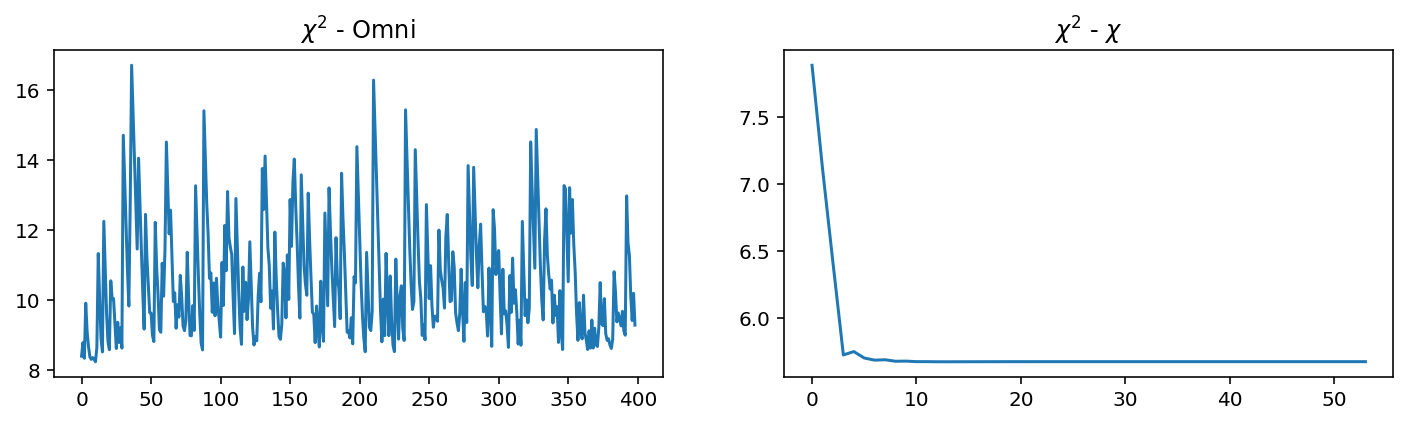

In [3385]:
fig, axes = plt.subplots(ncols=2, figsize=(12,3))

axes[0].plot(np.log10(omnichi[:omnin]))
axes[0].set_title(r"$\chi^2$ - Omni")

axes[1].plot(np.log10(chichi[:chin]))
axes[1].set_title(r"$\chi^2$ - $\chi$");

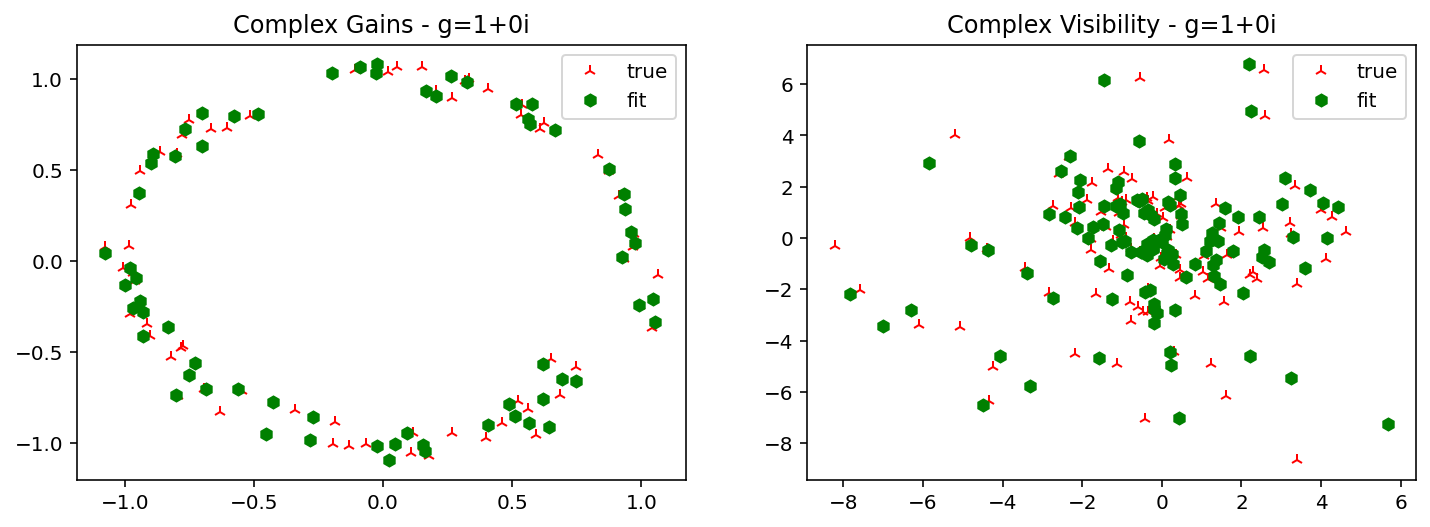

In [3386]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(gchi.real, gchi.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(vchi.real, vchi.imag, 'gh', label='fit')
axes[1].legend();

In [50]:
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))

# axes[0].set_title('Complex Gains - %s' % title_mod)
# axes[0].plot(tgain.real, 'r.', label='true')
# axes[0].plot(tgain.imag, 'b.', label='true')
# axes[0].plot(garr.real, 'rx', label='fit')
# axes[0].plot(garr.imag, 'bx', label='fit')
# axes[0].legend();

# axes[1].set_title('Complex Visibility - %s' % title_mod)
# axes[1].plot(valpha.real, 'r.', label='true')
# axes[1].plot(valpha.imag, 'b.', label='true')
# axes[1].plot(varr.real, 'rx', label='fit')
# axes[1].plot(varr.imag, 'bx', label='fit')
# axes[1].legend();

In [2125]:
def chifunc_ls(zs):
    # trying scipy least squares
    garr = zs[0:telescope_number]
    varr = zs[telescope_number:]
    value, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
    return np.linalg.norm(observation_baselines - value)

In [2229]:
def make_jac(x):
    # Making jacobian vector
    gains_off = 2*telescope_number
    garr = x[:telescope_number] + 1j*x[telescope_number:gains_off]
    varr = x[gains_off:gains_off+n_bases] + 1j*x[gains_off+n_bases:]
    jac_vec = np.zeros(len(x), dtype=np.complex128)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g2 = np.conj(garr[k])
            jac_term = np.conj(garr[i])*np.abs(g2*vterm)**2 - g2*vterm*np.conj(observation_baselines[i,k])
            jac_vec[i] += jac_term
            jac_vec[i+telescope_number] += 1j*jac_term
    for l in range(gains_off, gains_off+n_bases):
        i = l - gains_off
        indxs = np.where(redundant_baselines[i]==1)
        clean_1 = []
        clean_2 = []
        for m,n in zip(*indxs):
            if m < n:
                clean_1.append(m)
                clean_2.append(n)
        new_indx = (clean_1, clean_2)
        jac_term = np.sum(np.abs(garr[clean_1] * garr[clean_2])**2*np.conj(varr[i]) - garr[clean_1]*np.conj(garr[clean_2])*np.conj(observation_baselines[clean_1, clean_2]))
        jac_vec[l] = jac_term
        jac_vec[l+n_bases] = 1j*jac_term
    return jac_vec

In [2170]:
def lsquare_tonormal(x):
    # Convert the real vector x into our desired gains and visibilities
    gains_off = 2*telescope_number
    garr = x[:telescope_number] + 1j*x[telescope_number:gains_off]
    varr = x[gains_off:gains_off+n_bases] + 1j*x[gains_off+n_bases:]
    return garr, varr

In [3387]:
def chiwrapper(x):
    # Wrapper function around our complex chi2 that takes real x 
    # Scipy least squares only works with real valued functions 
    garr, varr = lsquare_tonormal(x)
    return chifunc_ls(np.concatenate((garr, varr)))

In [2206]:
gguess = tgain*np.exp(1j*np.random.uniform(-np.pi/6, np.pi/6, telescope_number))

In [2213]:
xguess = np.concatenate((gguess.real, gguess.imag, vguess.real, vguess.imag))

In [2214]:
xscale = np.concatenate((np.abs(gguess), np.abs(gguess), np.abs(vguess), np.abs(vguess)))

In [2226]:
lmfit = optimize.least_squares(chiwrapper, xguess, jac=make_jac, verbose=2, max_nfev=100, x_scale=xscale)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3927e+03                                    9.03e+03    
       1             16         2.3927e+03      0.00e+00       0.00e+00       9.03e+03    
`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 2.3927e+03, final cost 2.3927e+03, first-order optimality 9.03e+03.


In [2227]:
garr, varr = lsquare_tonormal(lmfit.x)

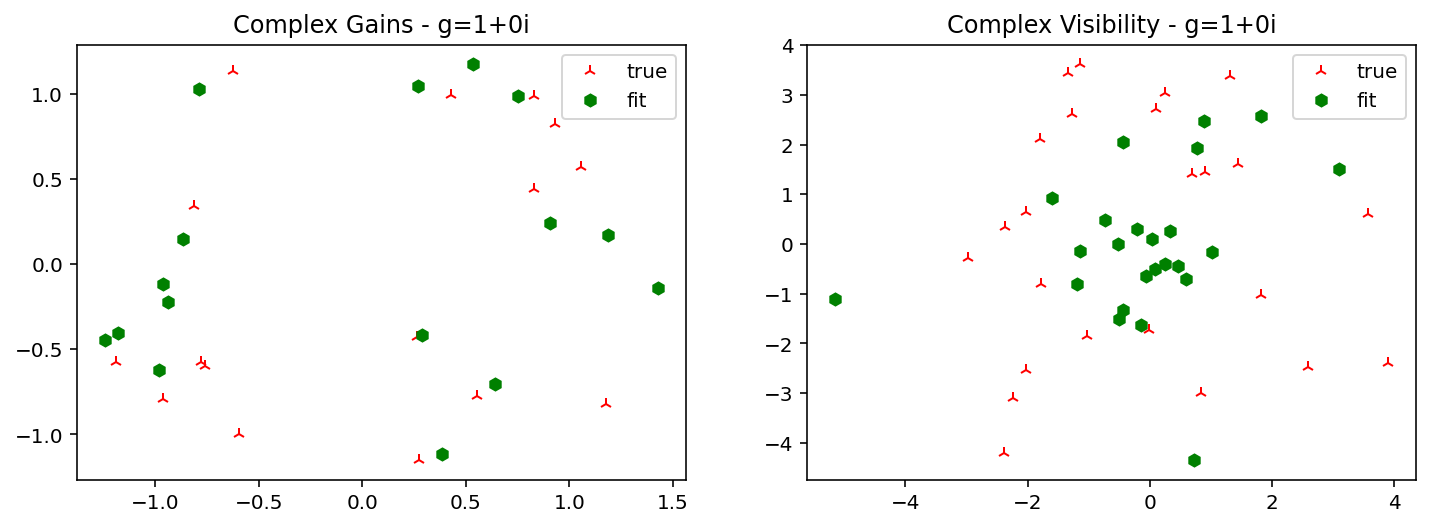

In [2228]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

In [2231]:
def graddescent_ls(zs):
    garr = zs[0:telescope_number]
    varr = zs[telescope_number:]
    value, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
    return np.linalg.norm(observation_baselines - value)

In [2236]:
def grad_jac(x):
    garr = x[:telescope_number]
    varr = x[telescope_number:]
    jac_vec = np.zeros(telescope_number + n_bases, dtype=np.complex128)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g2 = np.conj(garr[k])
            jac_term = np.conj(garr[i])*np.abs(g2*vterm)**2 - g2*vterm*np.conj(observation_baselines[i,k])
            jac_vec[i] += jac_term
    for l in range(telescope_number, telescope_number+n_bases):
        i = l - telescope_number
        indxs = np.where(redundant_baselines[i]==1)
        clean_1 = []
        clean_2 = []
        for m,n in zip(*indxs):
            if m < n:
                clean_1.append(m)
                clean_2.append(n)
        new_indx = (clean_1, clean_2)
        jac_term = np.sum(np.abs(garr[clean_1] * garr[clean_2])**2*np.conj(varr[i]) - garr[clean_1]*np.conj(garr[clean_2])*np.conj(observation_baselines[clean_1, clean_2]))
        jac_vec[l] = jac_term
    return jac_vec

In [2263]:
grad_guess = np.concatenate((gguess, vguess))

In [2265]:
graddescent_ls(grad_guess)

69.17613827782468

In [2274]:
gnew = grad_guess

In [2275]:
gnew -= .1*grad_jac(grad_guess)

In [2276]:
graddescent_ls(gnew)

6019912239756.458

In [2266]:
def simple_grad_descent(x, reps, delstep=.2):
    cost = np.zeros(reps, dtype=np.complex128)
    iterx = x.copy()
    for n in range(reps):
        grad = grad_jac(iterx)
        iterx -= delstep*grad
        cost[n] = graddescent_ls(iterx)
    return iterx, cost

In [2267]:
finx, cost = simple_grad_descent(grad_guess, 10, .1)

<ipython-input-2236-bf5e44f36641>:16: RuntimeWarning: overflow encountered in double_scalars
  jac_term = np.conj(garr[i])*np.abs(g2*vterm)**2 - g2*vterm*np.conj(observation_baselines[i,k])
<ipython-input-2236-bf5e44f36641>:28: RuntimeWarning: overflow encountered in square
  jac_term = np.sum(np.abs(garr[clean_1] * garr[clean_2])**2*np.conj(varr[i]) - garr[clean_1]*np.conj(garr[clean_2])*np.conj(observation_baselines[clean_1, clean_2]))
<ipython-input-2266-2f0a4a9af675>:6: RuntimeWarning: invalid value encountered in multiply
  iterx -= delstep*grad


In [3106]:
uv_points, _ = make_uv_points(tgain, valpha, noise_amp=0, noise_sig=0)

In [3189]:
n_sigma = np.zeros((telescope_number, telescope_number))+(.005**2 + .005**2*1j)

In [3190]:
np.tril(np.abs(observation_baselines-uv_points)**2/(n_sigma.real**2*2)).sum()/degree_of_freedoms

55900.809319025306

In [3188]:
(64*63)*.005

20.16